# Using Time Series to more accurately predict wave heights

In [1]:
import utilities.misc as misc
import utilities.metrics as mtr
import utilities.ml_functions as ml
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import math 
import numpy as np
from matplotlib import cm

In [2]:
# convert datetime to unix
# df = pd.read_csv('clean_weather/valid_dates/m1_valid_dates.csv')
# df = pd.read_csv('clean_weather/valid_data/m1_valid.csv')
df = pd.read_csv('clean_weather/valid_dates/m2_valid_dates.csv')
# df = pd.read_csv('clean_weather/valid_data/m2_valid.csv')

start_date = min(df['time'])
end_date = max(df['time'])

df['timestamps'] = (df['date'] + ' ' +df['time'])
df['timestamps'] = pd.to_datetime(df['timestamps'])
df['timestamps'] = (df['timestamps'] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')  

df.head()


,Unnamed: 0,time,station_id,AtmosphericPressure,WindDirection,WindSpeed,Gust,WaveHeight,WavePeriod,MeanWaveDirection,Hmax,SeaTemperature,date,timestamps
0,1953,00:00:00,M2,1020.0,330.0,2.92,3.9,0.6,4.0,NaN,NaN,8.6,2001-05-05,989020800
1,1955,01:00:00,M2,1020.8,330.0,4.09,5.8,0.4,4.0,NaN,NaN,8.6,2001-05-05,989024400
2,1957,02:00:00,M2,1020.8,350.0,4.09,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989028000
3,1959,03:00:00,M2,1021.2,350.0,1.95,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989031600
4,1961,04:00:00,M2,1021.4,30.0,2.92,5.8,0.4,4.0,NaN,NaN,8.7,2001-05-05,989035200


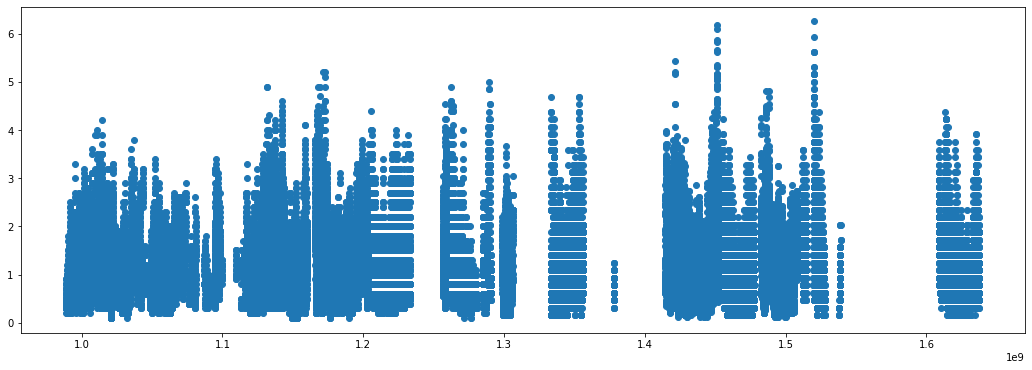

In [3]:
plt.figure(figsize=(18,6))

plt.scatter(df['timestamps'], df['WaveHeight'])
# plt.plot(df['timestamps'], df['WaveHeight'], color = 'red')


### Need to cut data into these chunks then try to predict

In [4]:
def chunkify(hours:int):
    """
    Splits dataframe into time chunks

    Parameters
    ----------
    hours : int


    Returns
    ----------
    chunk_df : pandas dataframe
    
    """
    num_hrs = len(df)
    # hours = 24
    num_chunks = int(num_hrs/hours)
    cols = []

    data = []
    for i in range(hours):
        cols.append(f"wind{i+1}")
        cols.append(f"wave{i+1}")
        cols.append(f"atmo{i+1}")

    chunk_df =pd.DataFrame(columns=[cols])

    for j in range(num_chunks):
        # for i in range(hours):
        #     wind.append(df['WindSpeed'][i])
        #     wave.append(df['WaveHeight'][i])
        #     atmo.append(df['AtmosphericPressure'][i])
        data = []

        for i in range(j*hours,j*hours+hours ):
            data.append(df['WindSpeed'][i])
            data.append(df['WaveHeight'][i])
            data.append(df['AtmosphericPressure'][i])
        
        chunk_df.loc[len(chunk_df)] = data

    return chunk_df

In [5]:
# two_hr = chunkify(2)
# three_hr = chunkify(3)
# four_hr = chunkify(4)
# six_hr = chunkify(6)
# eight_hr = chunkify(8)
# twelve_hr = chunkify(12)
twentyfour_hr = chunkify(24)
